__Huzzah.__ Our new competition predicting fog water collection from weather data is up! Let's put on our DATA SCIENCE HATS and get to work.

![](http://blog.drivendata.org/images/data-hat.jpg)

### TL;DR version

Here's what we're doing right now: looking at the microclimate measurements as independent snapshots in time as predictors of the outcome variable.

### Cool stuff we're not doing (but that the winners will undoubtedly explore)

Here's what we're NOT doing right now:

* Using macro-climate weather data at different levels of sampling to add information and reduce variance.
* Any form of time series modeling, like, at all.
* Incorporating more complex models of the underlying system we wish to model in order to mitigate noisy measurements.

Here's a new term for y'all courtesy of the DrivenData team:

<div class="alert alert-info"><strong>BM;IC</strong> Basic Model; Ignored Complexity</div>

Somebody throw it on Urban Dictionary — let's make fetch happen. Okay, time to load up the tools of the trade.

In [59]:
%matplotlib inline
from __future__ import print_function

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

### Loading the data

For this benchmark, we are only going to use microclimate data.

In [60]:
microclimate_train = pd.read_csv('data/eaa4fe4a-b85f-4088-85ee-42cabad25c81.csv',
                                 index_col=0, parse_dates=[0])

microclimate_test = pd.read_csv('data/fb38df29-e4b7-4331-862c-869fac984cfa.csv',
                                index_col=0, parse_dates=[0])

labels = pd.read_csv('data/a0f785bc-e8c7-4253-8e8a-8a1cd0441f73.csv',
                     index_col=0, parse_dates=[0])

submission_format = pd.read_csv('data/submission_format.csv',
                                index_col=0, parse_dates=[0])

### Looking at the training data (we are given labels for these)

First of all, let's just "walk around" this data a bit, and use the common summary functions to get a better idea for what it looks like.

In [61]:
microclimate_train.shape

(5802, 9)

In [62]:
microclimate_train.describe()

,percip_mm,humidity,temp,leafwet450_min,leafwet460_min,leafwet_lwscnt,gusts_ms,wind_dir,wind_ms
count,5781.000000,5781.000000,5781.000000,5781.000000,4617.000000,5781.000000,5794.000000,5794.000000,5794.000000
mean,0.078972,0.554852,15.566805,0.991033,0.799972,457.476362,3.381701,135.184925,2.827167
std,0.973970,0.282715,7.126274,1.903983,1.743959,48.172783,1.832613,96.186550,1.637490
min,0.000000,0.000000,0.000000,0.000000,0.000000,297.625000,0.000000,0.000000,0.000000
25%,0.000000,0.319978,9.937500,0.000000,0.000000,438.583333,2.007544,60.760417,1.588485
50%,0.000000,0.496859,14.470833,0.000000,0.000000,441.625000,3.143336,102.041667,2.619792
75%,0.000000,0.827473,20.937500,0.000000,0.000000,447.000000,4.538977,209.656250,3.867351
max,24.250000,1.072792,36.508334,5.173913,5.000000,1023.000000,11.518700,355.000000,10.092204


In [63]:
microclimate_train.tail()

,percip_mm,humidity,temp,leafwet450_min,leafwet460_min,leafwet_lwscnt,gusts_ms,wind_dir,wind_ms
2015-12-22 14:00:00,0,0.342318,15.287500,0,0,439.041667,4.471919,78.458333,3.277452
2015-12-22 16:00:00,0,0.343302,14.754167,0,0,439.958333,3.109807,80.166667,2.099749
2015-12-22 18:00:00,0,0.351736,13.675000,0,0,440.916667,3.344510,71.375000,2.556580
2015-12-22 20:00:00,0,0.363110,12.862500,0,0,441.000000,4.375524,72.875000,3.973177
2015-12-22 22:00:00,0,0.377436,12.741667,0,0,441.000000,4.798827,65.333333,4.400671


In [64]:
microclimate_train.isnull().sum(axis=0)

percip_mm           21
humidity            21
temp                21
leafwet450_min      21
leafwet460_min    1185
leafwet_lwscnt      21
gusts_ms             8
wind_dir             8
wind_ms              8
dtype: int64

Here's the big takeway: **we will have to deal with some missing values**.

### Looking at the test data (we will be predicting labels for these rows)

In [65]:
microclimate_test.shape

(1110, 9)

In [66]:
microclimate_test.describe()

,percip_mm,humidity,temp,leafwet450_min,leafwet460_min,leafwet_lwscnt,gusts_ms,wind_dir,wind_ms
count,1110.000000,1110.000000,1110.000000,1110.000000,918.000000,1110.000000,1110.000000,1110.000000,1110.000000
mean,0.015060,0.517156,15.563383,0.884949,0.527505,453.707082,3.348732,132.093260,2.805653
std,0.154859,0.265408,6.979713,1.816510,1.448019,35.884056,2.051050,94.138572,1.831789
min,0.000000,0.052849,2.237500,0.000000,0.000000,374.666667,0.000000,0.000000,0.000000
25%,0.000000,0.300331,10.662500,0.000000,0.000000,438.333333,1.857712,58.104167,1.433361
50%,0.000000,0.455093,14.272917,0.000000,0.000000,440.895833,2.902347,100.500000,2.405700
75%,0.000000,0.719250,20.813542,0.000000,0.000000,444.833333,4.625943,209.270833,3.971081
max,3.575000,1.037941,35.525000,5.041667,5.000000,690.833333,10.276614,349.666667,9.354568


In [67]:
microclimate_train.isnull().sum(axis=0)

percip_mm           21
humidity            21
temp                21
leafwet450_min      21
leafwet460_min    1185
leafwet_lwscnt      21
gusts_ms             8
wind_dir             8
wind_ms              8
dtype: int64

So again, we will definitely need to pay attention to missing values and figure out smart ways to deal with that. File under: *#datascientistproblems*.

Let's also plot all the data points in the training and test data to get a sense for how the data set is split:

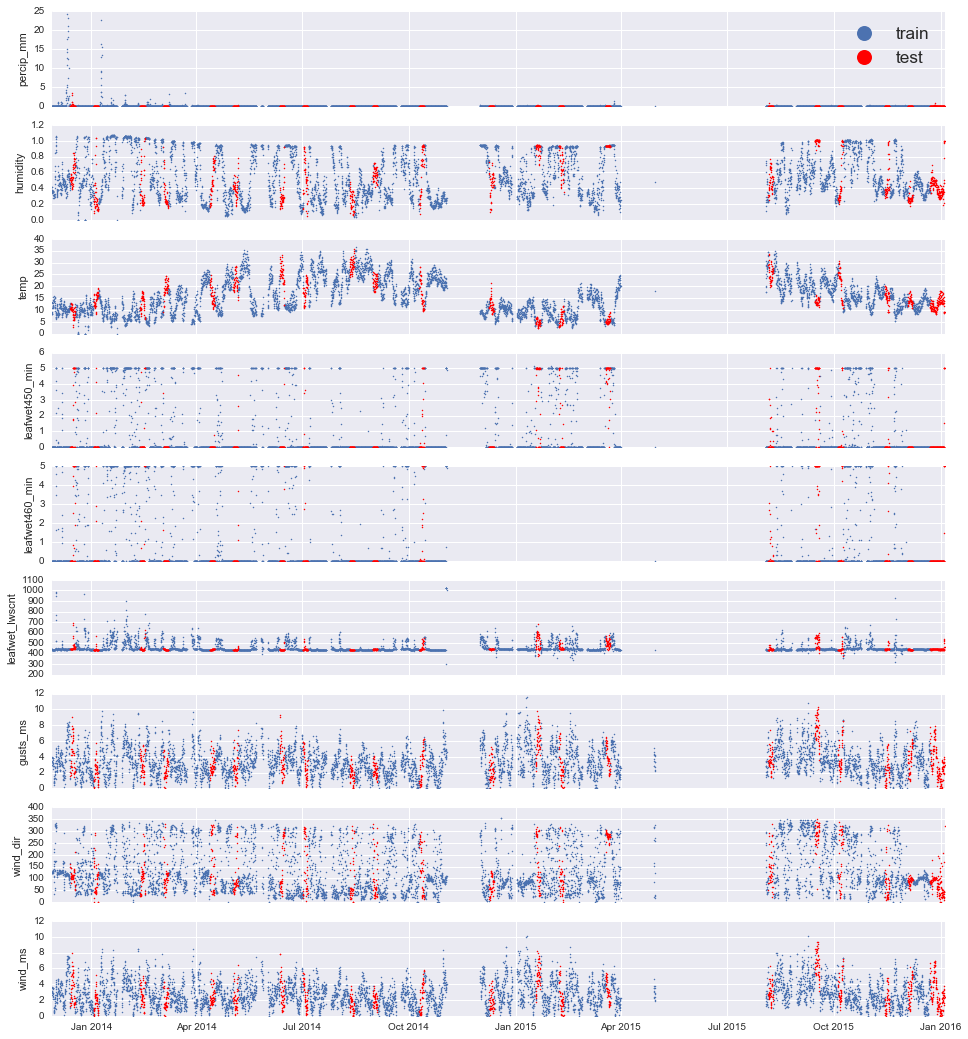

In [68]:
fig, axs = plt.subplots(nrows=microclimate_train.shape[1], ncols=1, sharex=True, figsize=(16, 18))

columns = microclimate_train.columns
for i, ax in list(enumerate(axs)):
    col = columns[i]
    ax.plot_date(microclimate_train.index, microclimate_train[col], ms=1.5, label='train')
    ax.plot_date(microclimate_test.index, microclimate_test[col], ms=1.5, color='r', label='test')
    ax.set_ylabel(col)
    
    if i == 0:
        ax.legend(loc='upper right', markerscale=10, fontsize='xx-large')

### This isn't your grandpa's random train/test split

Here's another fun insight: this problem has a time component and in the real world we are trying to **predict the future**. That is, we're trying to figure out the **upcoming** yield based on **current** weather. For those of us concerned about overfitting (hint: all of us), we will need to think hard about our modeling assumptions.

So, things that we could do all willy nilly but *probably* shouldn't:

* Imputing missing values using all of the data.
* Treating every data point as if it stands alone and is independent from other points in time.
* Drawing on weather that hasn't happened yet to inform our current predictions.

But this is a benchmark and we're not all about rules on this blog. Watch us break every single one of these cautionary warnings below! (That's why they call it a benchmark. (Actually that statement doesn't make sense, we don't know why it's called a benchmark. (HOLY MOLY, TOO MANY PARENTHESES #inception #common-lisp)))

### Looking at relationships between inputs and yield

In [69]:
print('train', microclimate_train.shape)
print('labels', labels.shape)

train (5802, 9)
labels (5802, 1)


In [70]:
microclimate_train.columns.tolist()

['percip_mm',
 'humidity',
 'temp',
 'leafwet450_min',
 'leafwet460_min',
 'leafwet_lwscnt',
 'gusts_ms',
 'wind_dir',
 'wind_ms']

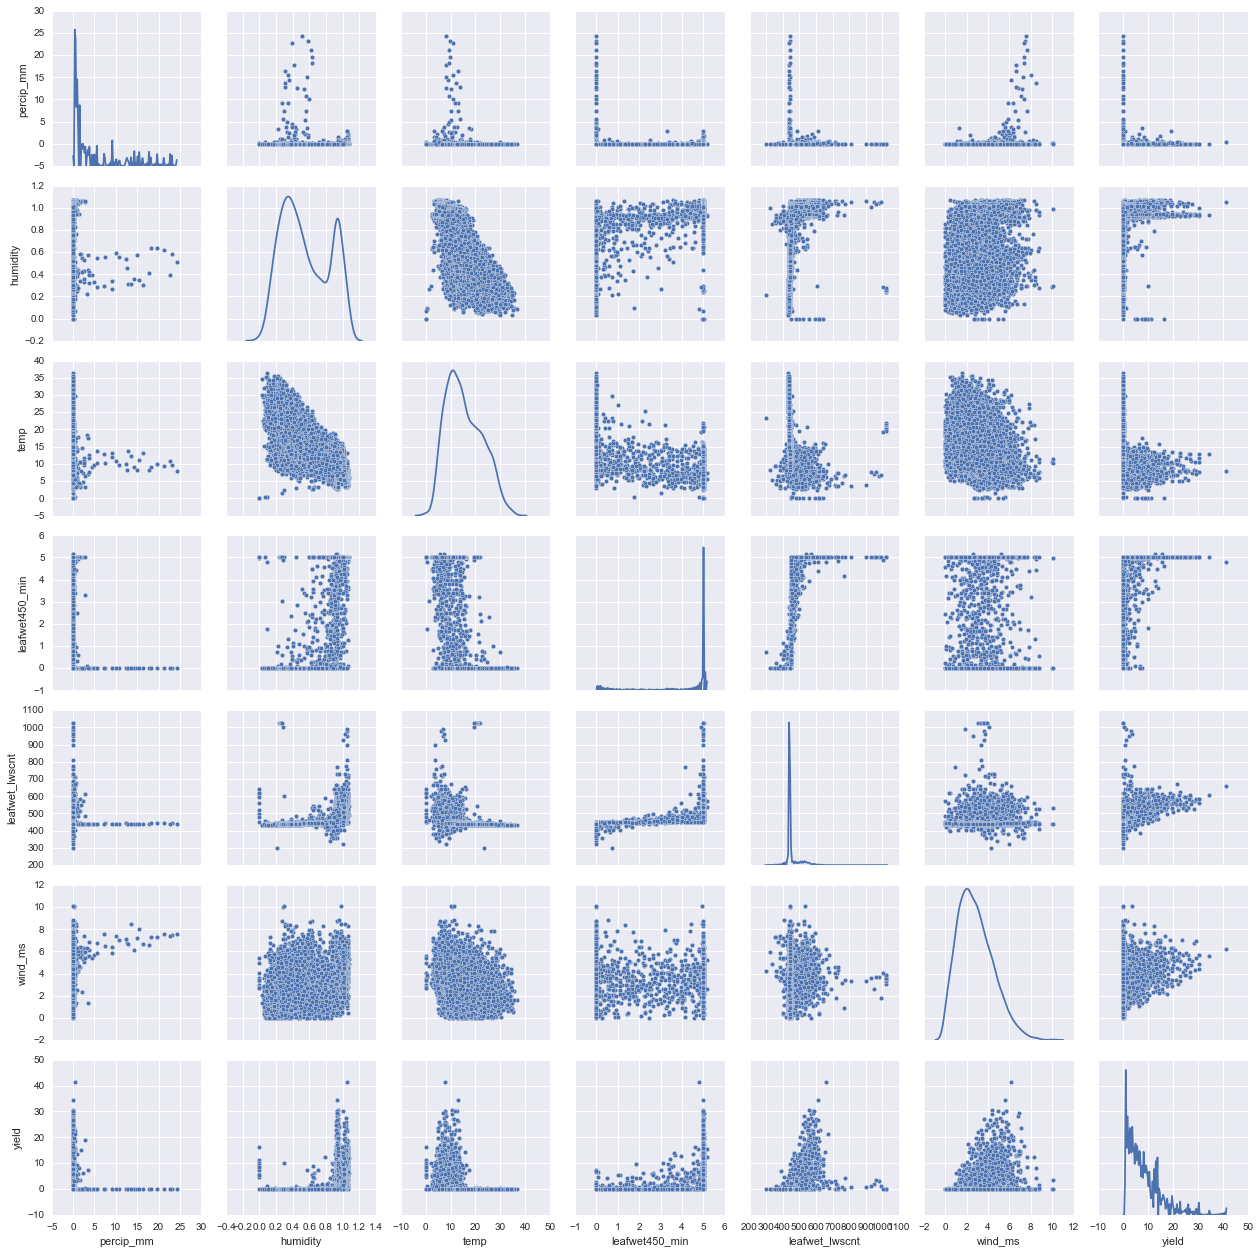

In [71]:
wanted_cols = [u'percip_mm', u'humidity', u'temp', u'leafwet450_min', u'leafwet_lwscnt', u'wind_ms']
wanted = microclimate_train[wanted_cols].copy().dropna()
wanted['yield'] = labels['yield']

sns.pairplot(wanted, diag_kind='kde')
plt.show()

We can see some relationships starting to emerge here, but maybe not as directly correlated with `yield` as we may have hoped.

### Splitting the data

Quick nomenclature check: we are training our model on the **competition's** training data, but we still need to use some cross validation techniques to avoid overfitting the heck out of the data.

<p>
<div class="alert alert-warning">
<strong>Spoiler alert:</strong> we still end up overfitting -- you'll see! When you submit your killer <em>AdaBoosted Neural TensorHustle&amp;Flow</em>, try not to do this. For bonus internet points on the <a href="http://community.drivendata.org/c/fog-nets">forum</a>, help our newer statistical modeling folks understand the limitations of this simple benchmark.
</div>

We'll go ahead and split up the competition training set into its own training and test sets for our modeling purposes here.

In [72]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(microclimate_train,
                                                    labels.values.ravel(),
                                                    test_size=0.3)

### Building a model pipeline

Here's a scikit-learn [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) which will handle a couple tasks for us in a well defined, repeatable way:

* Setting up an imputer to replace missing data.
* Try out some dimensionality reduction with PCA.
* Train the world's most naive random forest classifier.

And we'll GRID SEARCH ALL THE THINGS, because, hey, **why not, right**???!1

<p>
<div class="alert alert-warning">
<strong>Spoiler alert:</strong> there's a pretty good reason why this might not be a great idea. First one to point out why can be the provisional mayor of our forum with zero compensation but with no real responsibility.
</div>

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

steps = [('imputer', Imputer()),
         ('pca', PCA()),
         ('rf', RandomForestRegressor())]
pipe = Pipeline(steps)

# create the grid search
params = {
    'pca__n_components': range(2, X_train.shape[1]),
    'imputer__strategy': ['mean', 'median', 'most_frequent'],
    'rf__n_estimators': [5, 10, 20]
}
estimator = GridSearchCV(pipe, param_grid=params, n_jobs=-1, verbose=1)
estimator.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   32.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('pca', PCA(copy=True, n_components=None, whiten=False)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=...imators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'imputer__strategy': ['mean', 'median', 'most_frequent'], 'pca__n_components': [2, 3, 4, 5, 6, 7, 8], 'rf__n_estimators': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [74]:
estimator.best_params_

{'imputer__strategy': 'most_frequent',
 'pca__n_components': 8,
 'rf__n_estimators': 10}

### Examine performance

The competition uses [root mean squared error](http://statweb.stanford.edu/~susan/courses/s60/split/node60.html) as the metric, so let's see how we do on that front.

In [75]:
from sklearn.metrics import mean_squared_error

y_hat = estimator.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
rmse

1.9769854609184392

We can also plot our actuals against our predicted values and see if there's a trend.

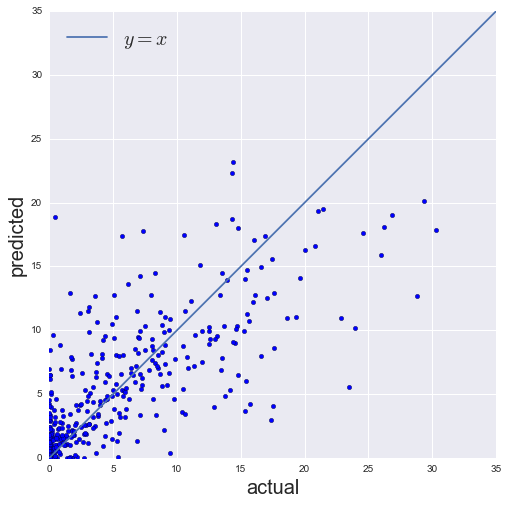

In [76]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(y_test, y_hat)

plt.xlabel('actual', fontsize=20)
plt.ylabel('predicted', fontsize=20)
plt.plot(np.linspace(0, 35), np.linspace(0, 35), label="$y=x$")

plt.xlim(0, 35)
plt.ylim(0, 35)
plt.legend(loc='upper left', fontsize=20)
plt.show()

Let's look at the residuals by themselves:

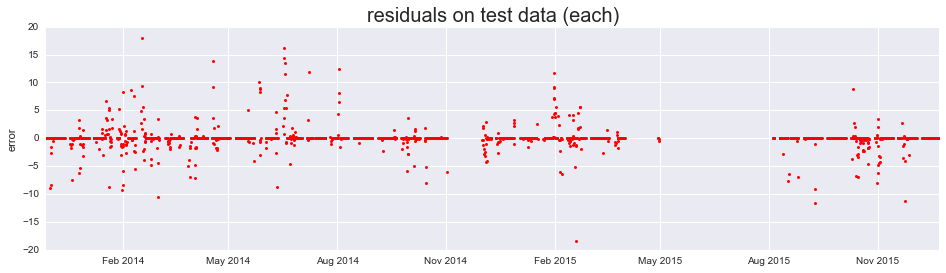

In [77]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_test - y_hat

ax.plot_date(X_test.index, err, c='r', ms=3)
ax.set_title('residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

And also look at the distribution of residuals.

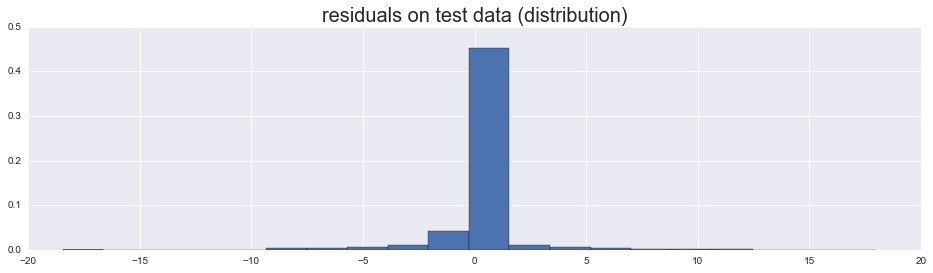

In [78]:
fig, ax = plt.subplots(figsize=(16, 4))
plt.hist(err, bins=20, normed=True)
plt.title('residuals on test data (distribution)', fontsize=20)
plt.xlim(-20, 20)
plt.show()

So we have our predictions in hand, and we have some idea of the error (although in practice this number only makes sense compared to other submissions — yet another great reason to give people a benchmark even with a very naive model!)

Time to make this into a submission.

### What should our submission look like?

So we know we need to predict the labels from the training inputs we were given, but let's just double check how it's supposed to look.

In [79]:
!head data/submission_format.csv

,yield
2013-11-24 00:00:00,0.0
2013-11-24 02:00:00,0.0
2013-11-24 04:00:00,0.0
2013-11-24 06:00:00,0.0
2013-11-24 08:00:00,0.0
2013-11-24 10:00:00,0.0
2013-11-24 12:00:00,0.0
2013-11-24 14:00:00,0.0
2013-11-24 16:00:00,0.0


In [80]:
submission_format.head()

,yield
2013-11-24 00:00:00,0
2013-11-24 02:00:00,0
2013-11-24 04:00:00,0
2013-11-24 06:00:00,0
2013-11-24 08:00:00,0


In [81]:
submission_format.dtypes

yield    float64
dtype: object

<div class="alert alert-warning"><strong>Careful.</strong> There is a gotcha here if we're not careful, which is that we are only using microclimate data in this benchmark and ignoring the other available data—but the microclimate test data has some missing values! How you deal with these is up to you (see above), but make sure you make predictions for every row expected in the submission format.</div>

In [82]:
submission_format.shape

(1590, 1)

In [83]:
microclimate_test.shape

(1110, 9)

We'll do a quick and dirty mitigation by making sure the test data we pass into our pipline has an input row for each and every expected row in the submission format, even if they are all NaNs.

An easy way to get the right index for our purposes is a <a href="https://en.wikipedia.org/wiki/Join_(SQL)#Left_outer_join">left outer join</a>, where the "left hand" table is our submission format and the "right hand table" is the microclimate data we have. The left join will link every row that has an identical index in both sets, but will fill the rows in microclimate that do not exist as NaNs.

Here's a helpful figure from the pandas docs:
![](http://blog.drivendata.org/images/merging_join_outer.png)

In [84]:
test = submission_format.join(microclimate_test, how='left')  # left join onto the format
test = test[microclimate_test.columns]  # now just subset back down to the input columns

assert (test.index == submission_format.index).all()

### Making our submission

We'll make predictions and fill in the yield column with actual outputs from our model:

In [85]:
submission_format['yield'] = estimator.predict(test)

In [86]:
estimator

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('pca', PCA(copy=True, n_components=None, whiten=False)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=...imators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'imputer__strategy': ['mean', 'median', 'most_frequent'], 'pca__n_components': [2, 3, 4, 5, 6, 7, 8], 'rf__n_estimators': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

Now we'll write it out to a file:

In [87]:
submission_format.to_csv("first_submission.csv")

And we can submit it to the competition and see what we end up with:

![](http://blog.drivendata.org/images/score.png)

**Ouch.** The overfitting police have come to calling. Note how we ended up scoring much more poorly on the withheld evaluation data than on our own withheld test set. That's a clear indication we overfit the data.

But the gauntlet has been thrown down. Will you step up to beat this ... *pettifogging* model?

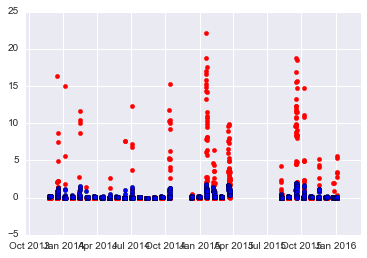

In [104]:
plt.scatter(submission_format.index,submission_format['yield'],color ='r')
plt.scatter(submission_format.index,hello['yield'])

In [103]:
hello = pd.read_csv('/Users/thorey/Documents/project/competition/fognet/models/lstm/model_0/h_250_rg_1e-07_lr_5e-05/submissions_20160318_182228.csv')

In [95]:
plt.plot(hello['yield'])
plt.plot(submission_format['yield'])

Error in callback <function post_execute at 0x10a9c9c08> (for post_execute):


ValueError: ordinal must be >= 1

ValueError: ordinal must be >= 1

In [91]:
hello

,Unnamed: 0,yield
0,2013-11-24 00:00:00,3.146034e-02
1,2013-11-24 02:00:00,3.351141e-02
2,2013-11-24 04:00:00,3.579708e-02
3,2013-11-24 06:00:00,3.797719e-02
4,2013-11-24 08:00:00,3.997364e-02
5,2013-11-24 10:00:00,4.183651e-02
6,2013-11-24 12:00:00,4.363881e-02
7,2013-11-24 14:00:00,4.543112e-02
8,2013-11-24 16:00:00,4.723621e-02
9,2013-11-24 18:00:00,4.905876e-02


In [106]:
import itertools

In [127]:
parameter_grid = {'lr': [1e-4,1e-3],'reg':[1e-6,1e-4],'hiddens':[25,100,250,500]}

In [112]:
    product = [x for x in apply(itertools.product, parameter_grid.values())]
    runs = [dict(zip(parameter_grid.keys(), p)) for p in product]

In [113]:
runs

[{'h': 25, 'lr': 0.0001, 'reg': 1e-06},
 {'h': 25, 'lr': 0.0001, 'reg': 0.0001},
 {'h': 25, 'lr': 0.001, 'reg': 1e-06},
 {'h': 25, 'lr': 0.001, 'reg': 0.0001},
 {'h': 100, 'lr': 0.0001, 'reg': 1e-06},
 {'h': 100, 'lr': 0.0001, 'reg': 0.0001},
 {'h': 100, 'lr': 0.001, 'reg': 1e-06},
 {'h': 100, 'lr': 0.001, 'reg': 0.0001},
 {'h': 250, 'lr': 0.0001, 'reg': 1e-06},
 {'h': 250, 'lr': 0.0001, 'reg': 0.0001},
 {'h': 250, 'lr': 0.001, 'reg': 1e-06},
 {'h': 250, 'lr': 0.001, 'reg': 0.0001},
 {'h': 500, 'lr': 0.0001, 'reg': 1e-06},
 {'h': 500, 'lr': 0.0001, 'reg': 0.0001},
 {'h': 500, 'lr': 0.001, 'reg': 1e-06},
 {'h': 500, 'lr': 0.001, 'reg': 0.0001}]

In [116]:
range(25, 500, 50)

[25, 75, 125, 175, 225, 275, 325, 375, 425, 475]

In [118]:
np.logspace(-7,-2,num=10)

array([  1.00000000e-07,   3.59381366e-07,   1.29154967e-06,
         4.64158883e-06,   1.66810054e-05,   5.99484250e-05,
         2.15443469e-04,   7.74263683e-04,   2.78255940e-03,
         1.00000000e-02])

In [128]:
all([f in  ['lr', 'reg', 'hiddens'] for f in parameter_grid.keys()])

True

In [129]:
config = {}

In [134]:
config.update(runs[8])

In [135]:
config

{'h': 250, 'lr': 0.0001, 'reg': 1e-06}